## QUBO 簡介
QUBO 是一種二元優化問題的表達形式，目標是透過調整一組二元變數來最小化一個二次目標函數。QUBO 主要形式如下：
​$f(x)=\Sigma_i Q_{ii}x_i+\Sigma{i<j}Q_{ij}x_i x_j$
其中：
$x_i$​ 為二元變數（0 或 1）。
$Q_{ii}$ 和 $Q_{ij}$​ 是 Q 矩陣中的係數。

QUBO 常應用於組合優化問題，如最大割 (Max-Cut)、旅行推銷員問題 (TSP)，以及子集和問題 (Subset Sum Problem)。

## Vertex Cover Problem
圖的覆蓋是一個頂點的集合，使圖中的每一條邊都至少連結該集合中的一個頂點。尋找最小的頂點覆蓋的問題稱為頂點覆蓋問題（Vertex cover），它是一個NP完全問題。
假設有一無向圖 $G = (V, E)$，其中 $V$ 為頂點集合，$E$ 為邊集合。頂點覆蓋是指從 $V$ 中選出一個子集 $C \subseteq V$，使得圖中每條邊 $e = (u, v)$ 至少有一個端點屬於 $C$。也就是說，對於所有邊 $(u,v) \in E$，必有 $u \in C$ 或 $v \in C$（或兩者皆屬）。

下圖是兩個頂點覆蓋問題的範例，紅點表示對於該圖來說的某個頂點覆蓋集合。 QUBO 的目標是求使用最少個頂點形成一個頂點覆蓋集。

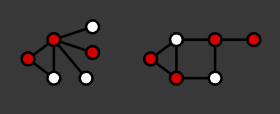

## 期中專案
期中專案請大家利用量子退火求解頂點覆蓋問題。程式至少能夠解決 keller4.mis 資料集，keller4 的最小覆蓋集是使用 160 個頂點，程式應該要輸出使用的頂點個數為 160。

報告書應包含：
1. 問題說明
2. QUBO 公式
3. 實驗結果
4. 心得

\\

其餘不拘。

### 評分標準
- 正確寫出 QUBO，並且能解決 keller4.mis 資料集 (40%)
- 問題描述和如何寫成 QUBO (15%)
- 說明實驗結果，實驗結果要比較使用的頂點個數（越少越好）。(10%)
- 解決 ee-class 上的其他資料集，有些資料集比較困難的可能需要嘗試調整 QUBO 權重，呈現在實驗結果當中，並說明使用哪些技巧進行實驗以及對結果的影響（如果有的話）(20%)
- 結論與心得(15%)

### 其他資料集
包含 keller4.mis 在內，我們還提供了另外五個資料集，作為 20% 中的分數，分別為 keller5、keller6、p_hat300-1、p_hat700-1和p_hat1500-1，這些資料集會上傳到 ee-class 作業區的 dataset.zip 中。



請利用這些資料集進行實驗，提出一個方法改進 QUBO 求解 VCP 的結果，在報告中說明你提出的方法，以及對於頂點覆蓋集的大小和結果有什麼影響。

### 資料集
資料的形式為 Edge List，以 keller4.mis 為例，部分資料如下，第一行是 `p edge 點的數量 邊的數量`，接著每一行描述一個邊所連接的兩個頂點 `e 頂點 頂點`。

keller4.mis 資料集：
```
p edge 171 5100                                   
e 1 2
e 1 3
e 1 4
e 1 5
e 1 6
e 1 7
e 1 9
e 1 10
e 1 11
e 1 18
e 1 28
e 1 29
e 1 31
e 1 32
.
.
.
```

下列程式碼將呈現如何讀入資料集，並且建構該圖的 networkx Grahp 物件。
networkx 是一個 python 套件，主要用來分析圖、網路等。我們將使用這個套件來儲存圖。
Network x: https://networkx.org/

In [2]:
import os, time
import networkx as nx
from pyqubo import Binary
from dwave.samplers import SimulatedAnnealingSampler, TabuSampler
from dwave.system import DWaveSampler, EmbeddingComposite

# solve

## keller4
* 這一段程式執行後不一定會得到最佳解 (160) 
* 但後續的 code (# Solve all datasets這邊) 有作優化並且可以穩定找到最佳解 

In [4]:
path = '../dataset/keller4.mis'
edges = []

with open(path) as f:
    for line in f:
        tokens = line.strip().split()
        if tokens[0] != 'e':
            continue
        u, v = map(int, tokens[1:3])
        edges.append((u, v))

G = nx.Graph()
G.add_edges_from(edges)

print(f"頂點數 |V| = {G.number_of_nodes()}")
print(f"邊數   |E| = {G.number_of_edges()}")

頂點數 |V| = 171
邊數   |E| = 5100


In [5]:
# networkx 讀進來的頂點編號可能從 1 開始；用一個 dict 做映射會最直觀
idx_map = {node: i for i, node in enumerate(G.nodes())}   # node → 0..n-1
n = len(idx_map)

# 建 n 個二元變數
x = [Binary(f"x{i}") for i in range(n)]

In [6]:

lam = 250

cost_term = sum(x[i] for i in range(n))

# penalty term: 對每一條邊 (u,v)，加入懲罰
penalty_term = sum(
    1 - x[idx_map[u]] - x[idx_map[v]] + x[idx_map[u]] * x[idx_map[v]]
    for u, v in edges
)

H = cost_term + lam * penalty_term


In [7]:
model = H.compile()
Q, offset = model.to_qubo()

In [18]:
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(Q, num_reads=1000, sweeps=10000) 

best = sampleset.first.sample  
best_energy = sampleset.first.energy + offset 
print("best solution: ", best)
print("Hamiltonian: ", best_energy)

best solution:  {'x0': 1, 'x1': 1, 'x10': 1, 'x100': 1, 'x101': 1, 'x102': 1, 'x103': 1, 'x104': 1, 'x105': 1, 'x106': 1, 'x107': 1, 'x108': 1, 'x109': 1, 'x11': 1, 'x110': 1, 'x111': 1, 'x112': 1, 'x113': 1, 'x114': 1, 'x115': 1, 'x116': 1, 'x117': 0, 'x118': 0, 'x119': 1, 'x12': 0, 'x120': 1, 'x121': 1, 'x122': 1, 'x123': 1, 'x124': 1, 'x125': 0, 'x126': 1, 'x127': 0, 'x128': 1, 'x129': 1, 'x13': 1, 'x130': 1, 'x131': 1, 'x132': 1, 'x133': 1, 'x134': 1, 'x135': 1, 'x136': 1, 'x137': 1, 'x138': 1, 'x139': 1, 'x14': 1, 'x140': 1, 'x141': 1, 'x142': 1, 'x143': 1, 'x144': 1, 'x145': 1, 'x146': 0, 'x147': 1, 'x148': 1, 'x149': 1, 'x15': 1, 'x150': 1, 'x151': 1, 'x152': 1, 'x153': 1, 'x154': 1, 'x155': 1, 'x156': 1, 'x157': 1, 'x158': 1, 'x159': 1, 'x16': 1, 'x160': 1, 'x161': 1, 'x162': 1, 'x163': 0, 'x164': 1, 'x165': 1, 'x166': 1, 'x167': 1, 'x168': 1, 'x169': 1, 'x17': 1, 'x170': 1, 'x18': 1, 'x19': 1, 'x2': 1, 'x20': 1, 'x21': 1, 'x22': 1, 'x23': 1, 'x24': 1, 'x25': 1, 'x26': 1, 'x27'

In [19]:
# check if the solution is valid
valid = True
for u, v in edges:
    if best[f"x{idx_map[u]}"] + best[f"x{idx_map[v]}"] == 0:
        valid = False
        break
print("valid solution: ", valid)

# check the number of nodes in the solution
total = 0
for i in range(n):
    if best[f'x{i}'] == 1:
        total += 1
print(f"total nodes = {total}")

valid solution:  True
total nodes = 160


# Solve all datasets

### define functions

In [ ]:
import os, time
import networkx as nx
from pyqubo import Binary
from dwave.samplers import SimulatedAnnealingSampler, TabuSampler
from dwave.system import DWaveSampler, EmbeddingComposite

DATA_DIR = "../dataset"
def load_dimacs(path):
    """讀取 .mis 檔案，回傳 networkx.Graph 與邊清單"""
    edges = []
    with open(path) as f:
        for line in f:
            if line.startswith('e '):
                _, u, v = line.split()
                edges.append((int(u), int(v)))
    G = nx.Graph();  G.add_edges_from(edges)
    return G, edges

def build_qubo(edges, n, lam):
    """以稀疏懲罰 1‑xu‑xv+xu*xv 建 QUBO"""
    x = [Binary(f"x{i}") for i in range(n)]
    idx = {v: i for i, v in enumerate(range(1, n+1))}  # DIMACS 節點從 1 起
    cost = sum(x)                                       # Σ x_i
    penalty = sum(1 - x[idx[u]] - x[idx[v]] + x[idx[u]] * x[idx[v]]
                  for u, v in edges)
    H = cost + lam * penalty
    Q, off = H.compile().to_qubo()
    return Q, off

def greedy_cleanup(sample, edges, n):
    """嘗試刪除冗餘頂點，維持覆蓋合法"""
    cover = {i for i in range(n) if sample[f"x{i}"] == 1}
    adj = [[] for _ in range(n)]
    for u, v in edges:
        adj[u-1].append(v-1); adj[v-1].append(u-1)
    for v in list(cover):
        cover.remove(v)
        if all((e[0]-1 in cover) or (e[1]-1 in cover) for e in edges):
            continue
        cover.add(v)
    return cover

def solve_instance(name, node_num, edge_num, sampler_kind, reads, lam=None, c=None, sweeps=None, timeout=None, beta_range=None, beta_schedule_type=None):
    path = os.path.join(DATA_DIR, name)
    G, edges = load_dimacs(path)
    n = G.number_of_nodes()
    if node_num != n:
        raise ValueError(f"節點數不正確！{node_num} != {n}")
    if len(edges) != edge_num:
        raise ValueError(f"邊數不正確！{len(edges)} != {len(G.edges())}")
    if lam is None:
        lam = (len(edges) / n) * c
    Q, off = build_qubo(edges, n, lam)

    if sampler_kind == "SA":
        sampler = SimulatedAnnealingSampler()
        if beta_range is None and beta_schedule_type is None:
            kwargs = {
                'num_reads': reads,
                'num_sweeps': sweeps or 10000,
            }
        else:
            kwargs = {
                'num_reads': reads,
                'num_sweeps': sweeps or 10000,
                'beta_range': beta_range or [0.01, 20],
                'beta_schedule_type': beta_schedule_type
            }
        if sweeps: kwargs["num_sweeps"] = sweeps
    elif sampler_kind == "QPU":
        sampler = EmbeddingComposite(DWaveSampler())
        kwargs = dict(num_reads=reads) 

    else:
        sampler = TabuSampler()
        kwargs = dict(num_reads=reads, timeout=timeout)

    t0 = time.time()
    result = sampler.sample_qubo(Q, **kwargs)
    best = result.first.sample
    raw_size = sum(best[f"x{i}"] for i in range(n))
    cover = greedy_cleanup(best, edges, n)
    t1 = time.time()
    # free memory
    del G, Q, off, result, best
    import gc

    # 每次 loop 後強制清除垃圾回收
    gc.collect()
    return {
        "name": name,
        "reads": reads,
        "sweeps": sweeps,
        "nodes": node_num,
        "edges": edge_num,
        "lam": round(lam, 2),
        "c": c,
        "MVC": len(cover),
        "MVC_raw": raw_size,
        "valid": all((u-1 in cover) or (v-1 in cover) for u, v in edges),
        "time_sec": round(t1 - t0, 1)
    }



### solve

In [9]:
config = {
    "keller4.mis": dict(
        node_num=171,
        edge_num=5100,
        # lam=250,
        c=5,
        sampler_kind="SA",
        reads=2000,
        sweeps=1000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "keller5.mis": dict(
        node_num=776,
        edge_num=74710,
        # lam=800,
        c=5,
        sampler_kind="SA",
        reads=2000,
        sweeps=2000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "keller6.mis": dict(
        node_num=3361,
        edge_num=1026582,
        # lam=1600,
        c=5,
        sampler_kind="SA",
        reads=5000,
        sweeps=5000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "p_hat300-1.mis": dict(
        node_num=300,
        edge_num=33917,
        # lam=350,
        c=5,
        sampler_kind="SA",
        reads=1000,
        sweeps=2500,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "p_hat700-1.mis": dict(
        node_num=700,
        edge_num=183651,
        # lam=700,
        c=5,
        sampler_kind="SA",
        reads=1000,
        sweeps=4000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    ),
    "p_hat1500-1.mis": dict(
        node_num=1500,
        edge_num=839327,
        # lam=1500,
        c=5,
        sampler_kind="SA",
        reads=1000,
        sweeps=6000,
        beta_range=[0.01, 20],
        beta_schedule_type="linear"
    )
}



results = {}
for file, cfg in config.items():
    print(f"\n▶ Solving {file}  …")
    res = solve_instance(file, **cfg)
    results[file] = res
    print(res)

print("\n===== SUMMARY =====")
# markdown table
header = ['name', 'MVC', 'reads', 'sweeps', 'nodes', 'edges', 'lam', 'c', 'MVC_raw', 'valid', 'time_sec']
print('| ', end='')
for h in header:
    print(f"{h:11s}", end=" | ")
print()
print(f"|{'-------------|'*(len(header))}")
for k,v in results.items():
    # print(f"{k:18s} | size={v['MVC_after_cleanup']:4} | raw={v['MVC_raw']:4} "
    #       f"| valid={v['valid']} | {v['time_sec']}s")
    print(f"| {k:11s}", end=" | ")
    for h in header[1:]:
        if h == 'name':
            v[h] = v[h][0:8]
        print(f"{v[h]:>11}", end=" | ")
    print()
print()
print("===== END =====")
print()
print()


▶ Solving keller4.mis  …
{'name': 'keller4.mis', 'reads': 2000, 'sweeps': 1000, 'nodes': 171, 'edges': 5100, 'lam': 149.12, 'c': 5, 'MVC': 160, 'MVC_raw': 160, 'valid': True, 'time_sec': 0.7}

▶ Solving keller5.mis  …
{'name': 'keller5.mis', 'reads': 2000, 'sweeps': 2000, 'nodes': 776, 'edges': 74710, 'lam': 481.38, 'c': 5, 'MVC': 749, 'MVC_raw': 749, 'valid': True, 'time_sec': 6.0}

▶ Solving keller6.mis  …
{'name': 'keller6.mis', 'reads': 5000, 'sweeps': 5000, 'nodes': 3361, 'edges': 1026582, 'lam': 1527.2, 'c': 5, 'MVC': 3305, 'MVC_raw': 3305, 'valid': True, 'time_sec': 199.9}

▶ Solving p_hat300-1.mis  …
{'name': 'p_hat300-1.mis', 'reads': 1000, 'sweeps': 2500, 'nodes': 300, 'edges': 33917, 'lam': 565.28, 'c': 5, 'MVC': 292, 'MVC_raw': 292, 'valid': True, 'time_sec': 1.3}

▶ Solving p_hat700-1.mis  …
{'name': 'p_hat700-1.mis', 'reads': 1000, 'sweeps': 4000, 'nodes': 700, 'edges': 183651, 'lam': 1311.79, 'c': 5, 'MVC': 689, 'MVC_raw': 689, 'valid': True, 'time_sec': 6.4}

▶ Solving